# Looking at REVISE Failures with Complicated Classifiers

We'll do all the same things as the first notebook, but we'll add more hidden layers to the classifier.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from jax.nn import relu, sigmoid
import matplotlib.pyplot as plt
import numpy as np


from nn_models import Feedforward
from vae import VAE
from revise import Revise

%matplotlib inline

## Generate Data

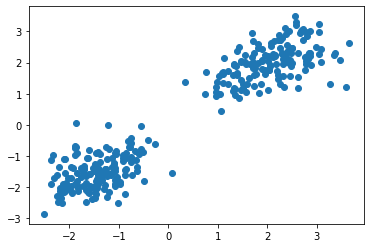

In [ ]:
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

np.random.seed(0)
indices = np.random.randint(2, size=300)
samples = [
    np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + 
           np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) 
           for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

## Construct Encoder, Decoder, VAE

In [ ]:
#decoder architecture
input_dim = 2
output_dim = 2
width = 50
hidden_layers = 1
activation_fn_type = 'relu'
activation_fn = relu
output_activation_type = 'linear'
output_activation_fn = lambda x: x
# activation_fn_type = 'linear'
# activation_fn = lambda x: x
decoder_architecture = {'width': [width] * hidden_layers,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None,
                'output_activation_type': output_activation_type,
                'output_activation_fn': output_activation_fn,
                'task': 'regression'}


#encoder architecture
input_dim = 2
output_dim = 4
width = 50
hidden_layers = 1
# activation_fn_type = 'relu'
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

encoder_architecture = {'width': [width] * hidden_layers,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None,
                'output_activation_type': output_activation_type,
                'output_activation_fn': output_activation_fn,
                'task': 'regression'}

vae = VAE(decoder_architecture, encoder_architecture, x_var)

In [ ]:
#import jax.profiler
#server = jax.profiler.start_server(9999)

In [ ]:
params = {
    'step_size':1e-2,
    'max_iteration':5000,
    'random_restarts':1,
 }

vae.fit(x_train.T, params=params, S=50)

Iteration 0 lower bound 452.1850; gradient mag: 779.7526
Iteration 100 lower bound 5.5786; gradient mag: 5.0560
Iteration 200 lower bound 3.9120; gradient mag: 2.8045
Iteration 300 lower bound 3.3382; gradient mag: 1.6626
Iteration 400 lower bound 3.0536; gradient mag: 2.4210
Iteration 500 lower bound 2.9344; gradient mag: 2.1321
Iteration 600 lower bound 2.8724; gradient mag: 7.6228
Iteration 700 lower bound 2.9269; gradient mag: 43.5206
Iteration 800 lower bound 2.8074; gradient mag: 11.4113
Iteration 900 lower bound 2.7711; gradient mag: 2.2391
Iteration 1000 lower bound 2.7621; gradient mag: 10.8130
Iteration 1100 lower bound 2.7721; gradient mag: 24.4413
Iteration 1200 lower bound 2.7246; gradient mag: 5.8354
Iteration 1300 lower bound 2.7155; gradient mag: 3.5920
Iteration 1400 lower bound 2.7005; gradient mag: 4.8378
Iteration 1500 lower bound 2.7103; gradient mag: 18.4154
Iteration 1600 lower bound 2.7974; gradient mag: 44.3672
Iteration 1700 lower bound 2.6811; gradient mag: 1

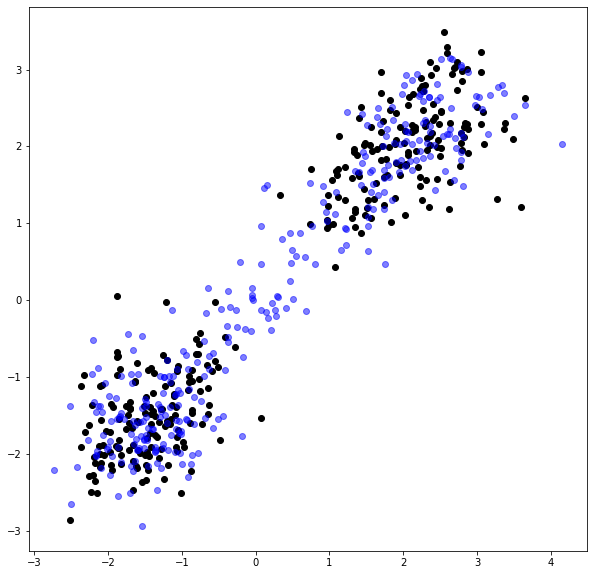

In [ ]:
x_hat = vae.generate(N=300)
x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x_train.T[0], x_train.T[1], color='black')
ax.scatter(x_hat[0], x_hat[1], color='blue', alpha=0.5)

plt.show()

## Build the Classifier

In [ ]:
width = 100
hidden_layers = 3
input_dim = 2
output_dim = 1
activation_fn_type = 'sigmoid'
activation_fn = sigmoid
output_activation_type = 'logistic'
output_activation_fn = sigmoid

classifier_architecture = {
    'width': [width] * hidden_layers,
    'hidden_layers': hidden_layers,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': activation_fn_type,
    'activation_fn': activation_fn,
    'activation_fn_params': None,
    'output_activation_type': output_activation_type,
    'output_activation_fn': output_activation_fn,
    'task': 'classification'
}

classifier = Feedforward(classifier_architecture)

In [ ]:
params = {
    'step_size':1e-3,
    'max_iteration':1000,
    'random_restarts':1,
 }

X_mean = x_train.mean()
X_std = x_train.std()
X_train = (x_train - X_mean) / X_std
classifier.fit(X_train.T, indices.reshape(1,-1), params)

Iteration 0 lower bound 560.3745; gradient mag: 1456.0037
Iteration 100 lower bound 0.7065; gradient mag: 3.3503
Iteration 200 lower bound 0.1497; gradient mag: 0.8029
Iteration 300 lower bound 0.0747; gradient mag: 0.3609
Iteration 400 lower bound 0.0517; gradient mag: 0.2358
Iteration 500 lower bound 0.0394; gradient mag: 0.1745
Iteration 600 lower bound 0.0315; gradient mag: 0.1376
Iteration 700 lower bound 0.0260; gradient mag: 0.1123
Iteration 800 lower bound 0.0219; gradient mag: 0.0938
Iteration 900 lower bound 0.0187; gradient mag: 0.0795



## Look at Predictions

In [ ]:
preds = classifier.predict(X_train)

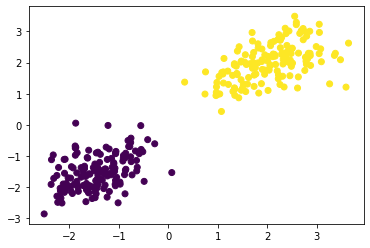

In [ ]:
plt.scatter(x_train.T[0], x_train.T[1], c=indices)

plt.show()

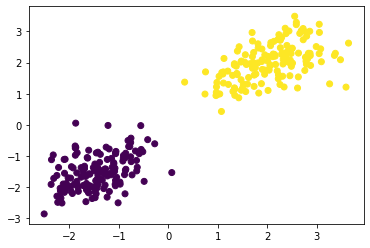

In [ ]:
plt.scatter(x_train.T[0], x_train.T[1], c=preds)

plt.show()

## Pick a Point for Recourse

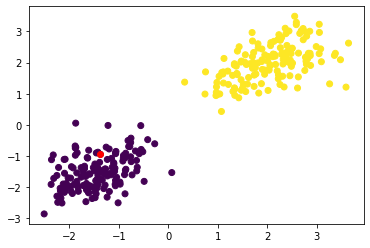

In [ ]:
chosen_point = x_train[3]
plt.scatter(x_train.T[0], x_train.T[1], c=indices)
plt.scatter(*chosen_point.T, color='red')

plt.show()

## Run REVISE and Generate Graphs

In [ ]:
revisor = Revise(classifier, vae)

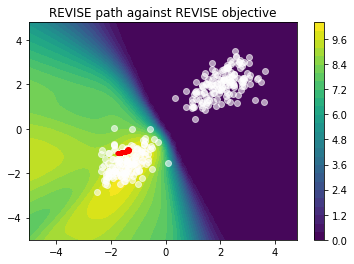

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-3, max_iter=500)
revisor.show_path(path, x_train)

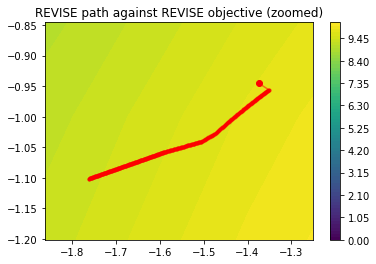

In [ ]:
revisor.show_path(path, zoom=True)

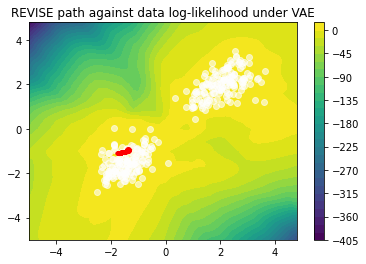

In [ ]:
revisor.show_path(path, x_train, landscape='likelihood')

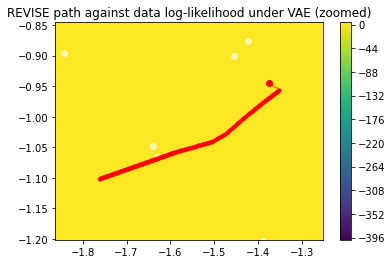

In [ ]:
revisor.show_path(path, x_train, zoom=True, landscape='likelihood')

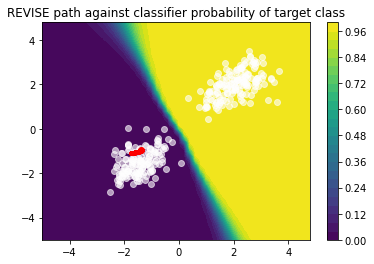

In [ ]:
revisor.show_path(path, x_train, landscape='prob_target')

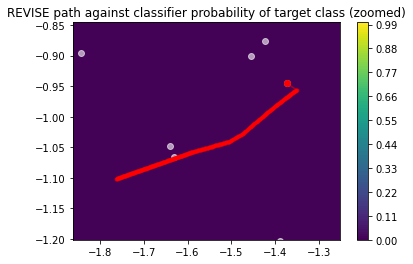

In [ ]:
revisor.show_path(path, x_train, zoom=True, landscape='prob_target')

The increased complexity of the classifier increased the complexity of the REVISE objective. With the same learning rate (the rate used throughout the CRUDS paper with their explorations with REVISE), we're stalling out and not finding a suitable point from which to build recourse. Let's try a different learning rate.

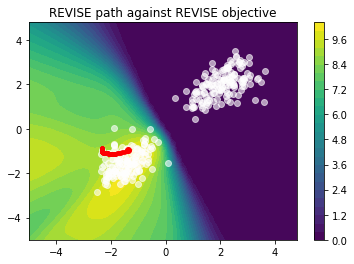

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-2, max_iter=500)
revisor.show_path(path, x_train)

We still didn't succeed. Let's try even higher.

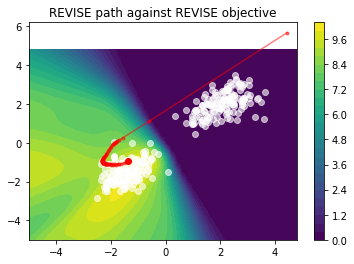

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-1, max_iter=500)
revisor.show_path(path, x_train)

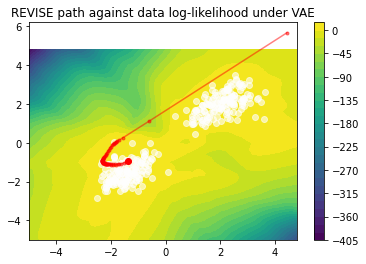

In [ ]:
revisor.show_path(path, x_train, landscape='likelihood')

We succeeded, but that doesn't look like desired behavior - we jumped way out.

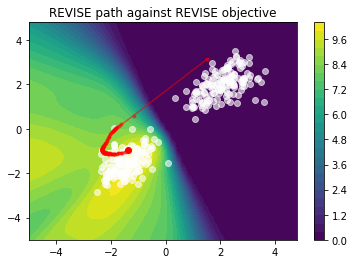

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=8e-2, max_iter=500)
revisor.show_path(path, x_train)

With this learning rate, we jumped into a pretty good place. But it was really tricky getting here. Will this work for other points?

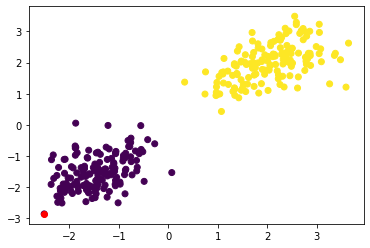

In [ ]:
chosen_point = x_train[226]
plt.scatter(x_train.T[0], x_train.T[1], c=indices)
plt.scatter(*chosen_point.T, color='red')

plt.show()

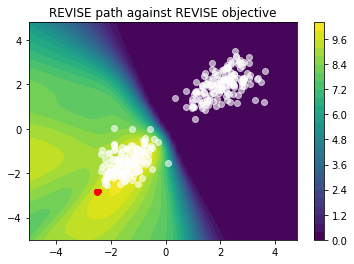

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-3, max_iter=500)
revisor.show_path(path, x_train)

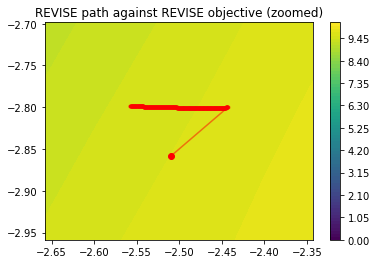

In [ ]:
revisor.show_path(path, zoom=True)

What the heck happened here? It looks like the gradient vanished. Let's try a higher learning rate.

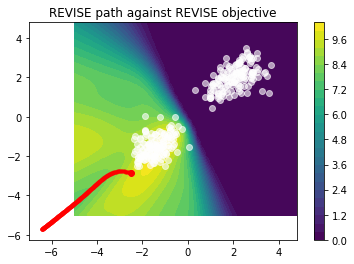

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-1, max_iter=500)
revisor.show_path(path, x_train)

With the larger learning rate, we're just walking away from the whole problem. That doesn't seem good.